## Imports

In [1]:
import os

%matplotlib inline
import string
import sys
import re
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

## Initial Thoughts on the Problem and the Dataset

On a high level, this dataset can be essentially split into two sections:

1. The first section is the demographic and personal details of each credit card client with features: ID, limit balance in NT dollars, sex, education level, marriage status, and age - a total of 6 features.
  
2. The second section is the usage and payment history across 6 months, namely repayment status, monthly bill amount, and monthly payment amount, for each of the 6 months respectively. This accounts for 18 features.

The 25th column, whether the client defaults the next month's payment (October), is what is known as "y" variable in machine learning terminology. We will be splitting this from the dataframe to create X_train and X_test respectively.

## Reading Dataset as pandas Dataframe

In [2]:
# Load the csv file
ccard_df = pd.read_csv("data/UCI_Credit_Card.csv", index_col=0)
ccard_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


<!-- END QUESTION -->

<br><br>

Below, the data is split into train (70%) and test (30%).

In [3]:
# Assign the columns to X and y
X = ccard_df.drop(columns="default.payment.next.month")
y = ccard_df["default.payment.next.month"]

# Split the data into X and y, and train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=76)


<!-- END QUESTION -->

<br><br>

## Exploratory Data Analysis (EDA)

In [4]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21000 entries, 8959 to 2722
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   21000 non-null  float64
 1   SEX                         21000 non-null  int64  
 2   EDUCATION                   21000 non-null  int64  
 3   MARRIAGE                    21000 non-null  int64  
 4   AGE                         21000 non-null  int64  
 5   PAY_0                       21000 non-null  int64  
 6   PAY_2                       21000 non-null  int64  
 7   PAY_3                       21000 non-null  int64  
 8   PAY_4                       21000 non-null  int64  
 9   PAY_5                       21000 non-null  int64  
 10  PAY_6                       21000 non-null  int64  
 11  BILL_AMT1                   21000 non-null  float64
 12  BILL_AMT2                   21000 non-null  float64
 13  BILL_AMT3                   21000 

### Observations
The features were described thoroughly on Kaggle. This dataset seems appropriate and useful for a classification problem using machine learning. As visible from the above information, all the features have 21000 non-null values, indicating that there are no missing values, which indicates that the data set is complete and does not need imputation. We have only int64 and float64 objects, indicating that there are only numeric features, and no categorical features. This means we do not need to encode text data into numeric data for further analysis. However, the scales are different, as we have binary values (which starts at 1), ordinal encoded values, raw value of age, among others.

### Some Potential Issues
For the PAY_X features, the description in Kaggle is missing what 0 and -2 means. The description is "(-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)". After looking through the discussion page, I found that "-2 corresponds to there being no credit to pay; and 0 corresponds to a payment being made on time but not the total amount to clear the balance. (Another way to think about this is that the minimum payment is met." This is in line with the ordinal encoding order of -1 to 9, and therefore is fine as is.

The feature "MARRIAGE" is ordinally encoded with values 0, 1, 2, 3. However, marriage status does not have an inherent order, and ordinal encoding is typically used in instances where there is an order or continuous relationship in the feature. Therefore, this would likely benefit from being one-hot encoded instead. The Kaggle does not have the definition for the 0, but the dataset has a few examples, where the marriage column has the value of 0. We are going to keep it and continue with the meaning that 0 means not willing to mention.

The binary values (particularly, of the feature 'sex') use 1-indexing, meaning they are encoded as '1' and '2' instead of '0' and '1'. This can be an issue as models might wrongly interpret the values 1 and 2 to be ordinal or continuous data rather than categorical. This is fixed using the binary transformation with the help of One-Hot-Encoder.

In [5]:
train_df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,167563.508571,1.604381,1.843905,1.554667,35.412952,-0.012190,-0.132714,-0.168333,-0.223143,-0.265762,...,43039.813952,40121.889810,38623.497095,5601.265286,6.059441e+03,5204.302571,4889.281333,4782.900857,5162.918714,0.221857
std,129919.112502,0.488995,0.789845,0.521970,9.136302,1.121864,1.196554,1.195375,1.165490,1.134210,...,63817.414980,60400.798292,59055.005208,16239.423781,2.407470e+04,16865.645456,16486.840852,15431.523094,17170.608569,0.415505
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2300.000000,1800.000000,1266.250000,1000.000000,8.200000e+02,390.000000,291.000000,257.750000,150.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,18990.000000,18091.000000,17127.000000,2112.500000,2.009000e+03,1801.500000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54740.000000,50065.250000,48950.500000,5012.000000,5.000000e+03,4531.250000,4048.500000,4078.000000,4001.000000,0.000000
max,800000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,706864.000000,823540.000000,568638.000000,873552.000000,1.684259e+06,889043.000000,621000.000000,426529.000000,528666.000000,1.000000


## Summary Statistics

From the describe table above, two summary statistics which I find useful:

1. 0.222 mean value of defaults on payment for the next month indicate that there is slight class imbalance. There are more data points with the negative class (non-default) than positive class(default). This also allows me to expect the results of predictions to hover around 20-25% defaults.
2. All the features have 21000 non-null values. There are no missing values in this dataset, which means imputation is not needed in the preprocessing step.

## Visualizations

For this visualization, I am exploring the data by overlaying the 0 and 1 classes on three features which are more relevant than others. For example, sex and marriage status do not inform a data scientist of a client's financial ability as much as education and limit balance might. As this is an EDA, these are just to get a better idea before creating models.

In [6]:
train_df.columns.unique()

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [7]:
visualize_cols = ['LIMIT_BAL', 'EDUCATION', 'PAY_6']

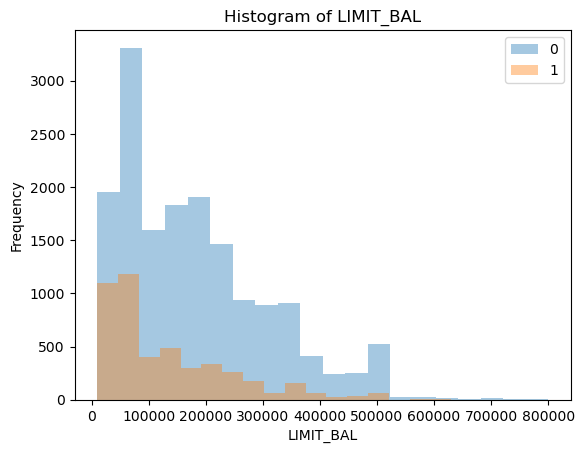

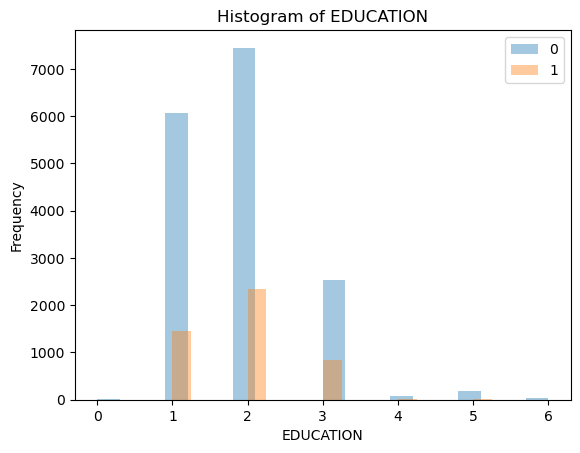

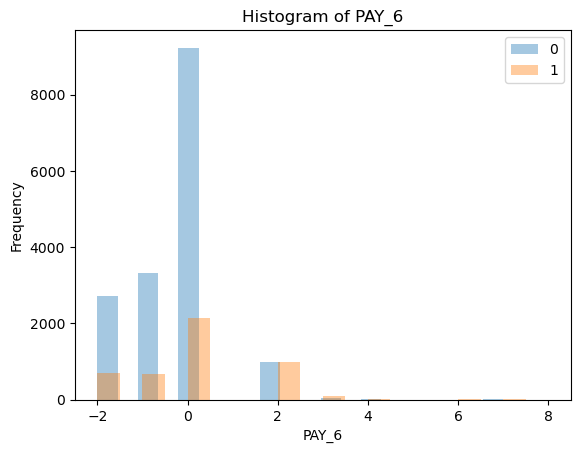

In [8]:
for feat in visualize_cols:
    ax = train_df.groupby("default.payment.next.month")[feat].plot.hist(bins=20, alpha=0.4, legend=True)
    plt.xlabel(feat)
    plt.title("Histogram of " + feat)
    plt.show()

### Thoughts on each of the histograms
1. Histogram of Limit Balance: The shape of both classes are very similar, with class 0 (not-default) being the majority of cases. This tells me that the limit balance might not be a great predictor of defaulting, as there is a consistent proportion of people in each limit balance bin that defaults.
   
2. Histogram of Education: Similar case as limit balance histogram. There is a consistent proportion of people in each education bin that defaults.

3. Histogram of Pay 6: This is the latest payment status before the month to predict default status. As seen above, there is a strong correlation between defaulting and previous months' failure to pay. There is a disproportionately high number of defaults for values of PAY_6 2 and above.

## Appropriate Metric: Recall

Out of all the classification metrics to predict whether the client will default, an appropriate metric would be recall. This is because, when a client defaults their loan, it incurs large costs to the bank. This means that the cost of false negatives is high, where false negatives are predictions labelling a client as non-default, when they will indeed default.

<!-- END QUESTION -->

<br><br>

# Data Processing

## Table of Feature Transformations

| Feature | Transformation | Explanation
| --- | ----------- | ----- |
| LIMIT_BAL | scaling |  A numeric feature with no missing values. Good idea to apply scaling, as the range of values (10,000 to 800,000) is quite different compared to other numeric features.|
| SEX | one-hot encoding | A binary feature that uses 1 and 2 instead of 0 and 1. Simple transformation to decrease all values by 1 to make it standard binary values of 0 and 1.
| EDUCATION | None | An ordinal feature where the highest education has the lowest integer value. 
| MARRIAGE | one-hot encoding | Originally an ordinal feature that should be one-hot encoded instead. Marriage status does not have an inherent order, and ordinal encoding is typically used in instances where there is an order or continuous relationship in the feature.
| AGE | scaling |  A numeric feature with no missing values. Good idea to apply scaling, as the range of values (21 to 79) is quite different compared to other numeric features.|
| PAY_X | none  |  An ordinal feature from -1 to 9 that does not need any preprocessing.
| BILL_AMTX | scaling | A numerical feature representing amount of bill statement in previous 1 to 6 months. Good idea to apply scaling, as the range of values is quite different compared to other numeric features. |
| PAY_AMTX | scaling  | A numerical feature representing payment amount in previous 1 to 6 months. Good idea to apply scaling, as the range of values is quite different compared to other numeric features.|

In [9]:
# Identify feature types

numeric_features = ["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
categorical_features = ["MARRIAGE"] # includes one-hot encoded
binary_features = ["SEX"]
ordinal_features = ["EDUCATION", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"] # Note that this is already ordinal, no need to preprocess

## Creating Transformers

In [10]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
binary_transformer = OneHotEncoder(drop = "if_binary")
# Ordinal features do not need to be transformed

In [11]:
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),  
    (categorical_transformer, categorical_features),
    (binary_transformer, binary_features),
    ("passthrough", ordinal_features)
)

## Transforming

In [12]:
transformed_df = pd.DataFrame(preprocessor.fit_transform(X_train), columns = numeric_features + list(preprocessor.named_transformers_["onehotencoder-1"].get_feature_names_out(categorical_features)) + list(preprocessor.named_transformers_["onehotencoder-2"].get_feature_names_out(binary_features)) + ordinal_features)
transformed_df.head(5)

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,MARRIAGE_2,MARRIAGE_3,SEX_2,EDUCATION,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,1.327292,0.939905,0.433921,0.516430,0.390631,0.255174,1.920088,1.212636,0.886674,-0.044007,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.249673,-0.154656,2.094514,1.813839,-0.625196,-0.657545,-0.637820,2.253487,-0.005990,-0.188312,...,1.0,0.0,1.0,2.0,0.0,0.0,0.0,-1.0,-1.0,-1.0
2,-0.674001,-1.030305,0.377072,0.441322,0.396381,0.507760,0.291611,0.330471,-0.172502,-0.135392,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.674001,1.049361,0.386305,0.456687,0.491731,0.568122,0.679148,0.712040,-0.152181,-0.122640,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.674001,0.502080,-0.657617,-0.660957,-0.211069,-0.647344,-0.654508,-0.491003,-0.219611,1.085587,...,0.0,0.0,1.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## Visualising the Transformed Dataframe

In [13]:
column_names = numeric_features + list(preprocessor.named_transformers_["onehotencoder-1"].get_feature_names_out(categorical_features)) + list(preprocessor.named_transformers_["onehotencoder-2"].get_feature_names_out(binary_features)) + ordinal_features 

transformed_df.describe()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,MARRIAGE_2,MARRIAGE_3,SEX_2,EDUCATION,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,...,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,2.639159e-17,-2.510584e-16,1.251909e-17,2.909842e-17,-6.022696e-17,9.812257e-18,-4.364763e-17,-1.725604e-17,4.906128e-18,1.353415e-17,...,0.534524,0.010952,0.604381,1.843905,-0.012190,-0.132714,-0.168333,-0.223143,-0.265762,-0.287381
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,...,0.498819,0.104081,0.488995,0.789845,1.121864,1.196554,1.195375,1.165490,1.134210,1.152388
min,-1.212810e+00,-1.577585e+00,-2.942023e+00,-1.672338e+00,-2.941144e+00,-3.338350e+00,-2.010880e+00,-4.194063e+00,-3.449259e-01,-2.516994e-01,...,0.000000,0.000000,0.000000,0.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-9.049193e-01,-8.113927e-01,-6.459431e-01,-6.481262e-01,-6.370447e-01,-6.383960e-01,-6.344751e-01,-6.325990e-01,-2.833459e-01,-2.176379e-01,...,0.000000,0.000000,0.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-2.121640e-01,-1.546562e-01,-3.950579e-01,-3.972948e-01,-3.868705e-01,-3.768624e-01,-3.647537e-01,-3.640167e-01,-2.148382e-01,-1.682488e-01,...,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.575640e-01,6.115363e-01,2.175711e-01,2.086617e-01,1.937376e-01,1.833428e-01,1.646269e-01,1.748751e-01,-3.628696e-02,-4.400748e-02,...,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.868041e+00,4.770867e+00,9.446184e+00,9.788265e+00,2.330441e+01,1.040218e+01,1.297064e+01,8.975143e+00,5.344841e+01,6.970969e+01,...,1.000000,1.000000,1.000000,6.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [14]:
assert set(column_names) == set(transformed_df.columns.unique())

<!-- END QUESTION -->

<br><br>

### Logistic Regression

Out of all the linear models that we have learned in this course. One of the linear models that is going to be used is logistic regression. One of the reasons behind choosing the logistic regression is that the model is able to use the linear function and compute the raw score, which later is used in the sigmoid function to predict, if the example, is a positive (1) or negative (0). Thus, it maintains its simplicity of running the model on a linear function, which is easy to understand and interpret. Now, lets create the logistic regression model with the default hyperparameter.

In [16]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs): #Adapted from lecture notes
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [17]:
default_result = {}
lr = LogisticRegression()
scoring = ["accuracy", "recall", "precision"]
scores = mean_std_cross_val_scores(lr, transformed_df, y_train, cv = 5, return_train_score = True, scoring = scoring)
default_result["logistic Regression Default"] = scores
display(pd.DataFrame(default_result).T)

/var/folders/z3/__52hny91dz_m7bg8pd9fvg80000gn/T/ipykernel_1863/3026881700.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall,test_precision,train_precision
logistic Regression Default,0.033 (+/- 0.002),0.003 (+/- 0.000),0.810 (+/- 0.005),0.810 (+/- 0.001),0.238 (+/- 0.017),0.239 (+/- 0.005),0.718 (+/- 0.025),0.718 (+/- 0.006)


### Hyperparameter optimization

From the previous code outputs, it can be concluded that there is less difference between the train and test score, with the train score being a little smaller score, which means that the logistic regression model, with the default hyperparameter of C = 1, may lead to under-fitting. Thus, some hyperparameter optimization may be needed. Now, let's move forward towards the computation of the hyperparameter optimization. One important thing to note is that we have very little recall, which is indeed a problem, as we want our recall to be of a reasonable number (at least 75% in our case), this is because we have a class imbalance, which can be resolved by adjusting the class weight of each class. Following are the different values of the hyperparameter C and also the class_weight that will be used in hyperparameter optimization.

In [18]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100], 
              "class_weight":["balanced", {0:1, 1:3}, {0:1, 1:5}, {0:1, 1:7}, {0:1, 1:9}]}
result_dict = {"C":[], "class_weight":[], "train_score":[], "test_score":[], "train_recall":[], "test_recall":[], "train_precision":[], "test_precision":[]}

In [19]:
results = {}

for c in param_grid["C"]:
    for weight in param_grid["class_weight"]:
        lr = LogisticRegression(C = c, class_weight = weight)
        scores = mean_std_cross_val_scores(lr, transformed_df, y_train, cv = 5, return_train_score = True, scoring = scoring)
        results["LR C = " + str(c) + " weight = " + str(weight)] = scores

/var/folders/z3/__52hny91dz_m7bg8pd9fvg80000gn/T/ipykernel_1863/3026881700.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/var/folders/z3/__52hny91dz_m7bg8pd9fvg80000gn/T/ipykernel_1863/3026881700.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/var/folders/z3/__52hny91dz_m7bg8pd9fvg80000gn/T/ipykernel_1863/3026881700.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labe

### Reporting results from the hyperparameter optimzation

In [20]:
scores_df = pd.DataFrame(results).T
display(scores_df)

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall,test_precision,train_precision
LR C = 0.001 weight = balanced,0.012 (+/- 0.002),0.003 (+/- 0.000),0.690 (+/- 0.006),0.692 (+/- 0.004),0.625 (+/- 0.013),0.628 (+/- 0.002),0.380 (+/- 0.006),0.382 (+/- 0.004)
"LR C = 0.001 weight = {0: 1, 1: 3}",0.013 (+/- 0.001),0.003 (+/- 0.000),0.774 (+/- 0.007),0.775 (+/- 0.003),0.519 (+/- 0.009),0.522 (+/- 0.004),0.491 (+/- 0.015),0.493 (+/- 0.006)
"LR C = 0.001 weight = {0: 1, 1: 5}",0.015 (+/- 0.001),0.003 (+/- 0.000),0.495 (+/- 0.005),0.496 (+/- 0.003),0.789 (+/- 0.010),0.790 (+/- 0.003),0.277 (+/- 0.003),0.277 (+/- 0.001)
"LR C = 0.001 weight = {0: 1, 1: 7}",0.018 (+/- 0.001),0.003 (+/- 0.000),0.375 (+/- 0.007),0.374 (+/- 0.004),0.898 (+/- 0.013),0.896 (+/- 0.001),0.248 (+/- 0.003),0.248 (+/- 0.001)
"LR C = 0.001 weight = {0: 1, 1: 9}",0.017 (+/- 0.001),0.003 (+/- 0.000),0.317 (+/- 0.005),0.319 (+/- 0.002),0.932 (+/- 0.009),0.932 (+/- 0.002),0.237 (+/- 0.002),0.237 (+/- 0.001)
LR C = 0.01 weight = balanced,0.017 (+/- 0.002),0.003 (+/- 0.000),0.691 (+/- 0.007),0.692 (+/- 0.004),0.634 (+/- 0.012),0.637 (+/- 0.003),0.382 (+/- 0.006),0.383 (+/- 0.004)
"LR C = 0.01 weight = {0: 1, 1: 3}",0.019 (+/- 0.001),0.003 (+/- 0.000),0.762 (+/- 0.009),0.762 (+/- 0.004),0.547 (+/- 0.008),0.547 (+/- 0.005),0.470 (+/- 0.017),0.469 (+/- 0.007)
"LR C = 0.01 weight = {0: 1, 1: 5}",0.025 (+/- 0.001),0.003 (+/- 0.000),0.508 (+/- 0.006),0.509 (+/- 0.004),0.778 (+/- 0.011),0.783 (+/- 0.003),0.281 (+/- 0.003),0.282 (+/- 0.002)
"LR C = 0.01 weight = {0: 1, 1: 7}",0.031 (+/- 0.002),0.003 (+/- 0.000),0.389 (+/- 0.007),0.389 (+/- 0.004),0.887 (+/- 0.014),0.886 (+/- 0.001),0.251 (+/- 0.003),0.251 (+/- 0.001)
"LR C = 0.01 weight = {0: 1, 1: 9}",0.032 (+/- 0.002),0.003 (+/- 0.000),0.327 (+/- 0.005),0.327 (+/- 0.003),0.926 (+/- 0.011),0.929 (+/- 0.002),0.238 (+/- 0.002),0.239 (+/- 0.001)


Since recall is the more important metric for this model, let us check from the above tables, for which values of the hyperparameters we have at least 75% recall. Since we are doing the hyperparameter optimization, we also need to check for accuracy as well. Since all the entries in the table we are looking for have a recall of greater than 0.75, we now only need to check for the best mean cross-validation score.

Now, from the table above, it can be concluded that the best mean validation score is for the hyperparameters of C = 1, and class_weight = {0:1, 1:5}. Since, that is the only model that has the recall of at least 75% and also have the best test/validation accuracy.

In [21]:
best_C = 1
best_weight = {0:1, 1:5}

print("The best C calculated is:", best_C)
print("The best class weight calculated is:", best_weight)

The best C calculated is: 1
The best class weight calculated is: {0: 1, 1: 5}


### Summary of the first linear model tried

From the first linear model tried, it can be concluded that in order to have a recall of at least 75%, we have a huge reduction in the model test accuracy to nearly 50%. Even though we have less test accuracy, there was another metric, we were more concerned of, which was recall. Since, we have set the recall to be at least 75%, which means out of all the true cases of the default, our model should predict at least 75% of them. Thus, we achieved that recall with the maximum accuracy at the hyperparameters of C = 1, and class_weight of default being 5 and non-default being 1 (0:1, 1:5). Following is the metric summary for the hyperparameters mentioned above.

In [22]:
display(scores_df.loc["LR C = " + str(best_C) + " weight = " + str(best_weight),:])

fit_time           0.038 (+/- 0.003)
score_time         0.003 (+/- 0.000)
test_accuracy      0.509 (+/- 0.007)
train_accuracy     0.511 (+/- 0.004)
test_recall        0.777 (+/- 0.010)
train_recall       0.781 (+/- 0.003)
test_precision     0.281 (+/- 0.003)
train_precision    0.282 (+/- 0.002)
Name: LR C = 1 weight = {0: 1, 1: 5}, dtype: object

<!-- END QUESTION -->

<br><br>

### RandomForestClassifier

Our first model to use is the Random Forest Classifier, which is a tree-based ensemble model, that creates many different decision trees and uses the majority vote to predict, whether the prediction is 1 or 0. Let's create the random forest classifier model and run a cross-validation on it, to compare the results with the linear model created above.

In [23]:
rf = RandomForestClassifier(n_jobs=-1,random_state=76, class_weight = {0:1, 1:5})

In [24]:
results_models = {}
results_models["RandomForestClassifier"] = mean_std_cross_val_scores(rf, transformed_df, y_train, cv = 5, return_train_score = True, scoring = scoring)
scores_df = pd.DataFrame(results_models).T
display(scores_df)

/var/folders/z3/__52hny91dz_m7bg8pd9fvg80000gn/T/ipykernel_1863/3026881700.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall,test_precision,train_precision
RandomForestClassifier,0.529 (+/- 0.010),0.018 (+/- 0.001),0.815 (+/- 0.003),1.000 (+/- 0.000),0.342 (+/- 0.010),1.000 (+/- 0.000),0.661 (+/- 0.018),0.998 (+/- 0.001)


Seeing, the results from the above table, it can be clearly seen that the model is over-fitting, as there is a lot of difference between the test_accuracy and train_accuracy. Also, we can clearly see that the model is not able to have a good or reasonable number for the test_recall, and there is a huge difference between those as well. Thus, concluding that even though we have a very high accuracy, our real and the most important metric: recall is not so huge or hasn't achieved the threshold of 75%, thus, it cannot beat the linear model (logistic regression), with the default hyperparameters. Also, the random forest classifier cannot beat the logistic regression in terms of the fit and score time, which also influences the decision of not being a good model, for this datsets, when we have default hyperparameters. Thus, There is a need for hyperparameter optimization to conclude whether it is good for this problem or not, after optimization.

### Support Vector Machines: SVM - RBF

Now, let us try the SVM - RBF model, and see if, we can achieve a better results or not. The SVM - RBF, is able to take some support vector features from the train datasets, which later is used to create a decision boundary. And the model uses those boundaries to predict the outcome of the examples presented. As mentioned, we are going to use the default hyperparameters for this model, but with the class_weight of {0:1, 1:5}. Since, with this class_weight we are able to compare the results of this model with the results of the linear model created above.

In [25]:
from sklearn.svm import SVC

svc = SVC(random_state=76, class_weight = {0:1, 1:5})
results_models["SVM-RBF"] = mean_std_cross_val_scores(svc, transformed_df, y_train, cv = 5, return_train_score = True, scoring = scoring)
scores_df = pd.DataFrame(results_models).T
display(scores_df)

/var/folders/z3/__52hny91dz_m7bg8pd9fvg80000gn/T/ipykernel_1863/3026881700.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall,test_precision,train_precision
RandomForestClassifier,0.529 (+/- 0.010),0.018 (+/- 0.001),0.815 (+/- 0.003),1.000 (+/- 0.000),0.342 (+/- 0.010),1.000 (+/- 0.000),0.661 (+/- 0.018),0.998 (+/- 0.001)
SVM-RBF,7.975 (+/- 0.087),2.816 (+/- 0.030),0.691 (+/- 0.013),0.714 (+/- 0.011),0.694 (+/- 0.014),0.744 (+/- 0.013),0.390 (+/- 0.012),0.419 (+/- 0.010)


Seeing the results for the SVM-RBF, it can clearly seen that the model is performing way better than the RandomForestClassifier, SVM-RBF has very good recall compared to the previous one, with a test recall score of 0.694 even though it is not able to achieve the threshold of 75% that was mentioned in the linear model. It has maintained to achieve an accuracy of 0.691, which is better than the linear model's (logistic regression) test accuracy. Moreover, comparing the difference of the test_accuracy and the train_accuracy, it can be said that the model may be under-fitting and it is a good indication for the hyperparameter optimization to increase the metric we want and also maintain the high accuracy at the same time. Currently, when comparing the SVM-RBF with the logistic regression model, we have created, it can be said that SVM-RBF is a good competitor for the best model, but with the default hyperparameter, it may beat the logistic regression, as we also want our accuracy to be higher, while maintaining the high recall as well. With hyperparameter optimization, we may be able to achieve a threshold of the recall, and may also beat the linear model, in terms of the accuracy as well. But, SVM-RBF has one drawback of having a high fit and score time compared to the fit and score time of the logistic regression model.

### Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=76, class_weight = {0:1, 1:5})
results_models["DecisionTree"] = mean_std_cross_val_scores(dt, transformed_df, y_train, cv = 5, return_train_score = True, scoring = scoring)
scores_df = pd.DataFrame(results_models).T
display(scores_df)

/var/folders/z3/__52hny91dz_m7bg8pd9fvg80000gn/T/ipykernel_1863/3026881700.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall,test_precision,train_precision
RandomForestClassifier,0.529 (+/- 0.010),0.018 (+/- 0.001),0.815 (+/- 0.003),1.000 (+/- 0.000),0.342 (+/- 0.010),1.000 (+/- 0.000),0.661 (+/- 0.018),0.998 (+/- 0.001)
SVM-RBF,7.975 (+/- 0.087),2.816 (+/- 0.030),0.691 (+/- 0.013),0.714 (+/- 0.011),0.694 (+/- 0.014),0.744 (+/- 0.013),0.390 (+/- 0.012),0.419 (+/- 0.010)
DecisionTree,0.260 (+/- 0.005),0.004 (+/- 0.000),0.733 (+/- 0.008),1.000 (+/- 0.000),0.393 (+/- 0.028),1.000 (+/- 0.000),0.396 (+/- 0.018),0.998 (+/- 0.001)


Seeing the results, it's clear to see that the DecisionTree model is overfitting; there is a large discrepancy between the validation accuracy and the training accuracy. This is also the case for the validation recall and training recall scores. Interestingly, the recall score of our single decision tree is slightly better than the score from our tree-based ensemble model. The score is still far too low however. The fitting and scoring time for the DecisionTree is the fastest out of the three models we've used here, but it is still slower than the linear model we used above.

## Hyperparameter Optimization of each model tried above

### RandomForestClassifier

In [27]:
rf_param_grid = {"n_estimators": np.arange(1, 100, 10), 
              "max_depth": np.arange(1, 20, 2)}
rf_random_search = RandomizedSearchCV(rf, param_distributions=rf_param_grid, n_iter=100, n_jobs=-1, return_train_score=True, scoring=scoring, refit='accuracy', random_state=76)
rf_random_search.fit(transformed_df, y_train)
rf_optimization_df = pd.DataFrame(rf_random_search.cv_results_)[
    [
        "mean_test_accuracy",
        "mean_test_recall",
        "mean_test_precision",
        "param_n_estimators",
        "param_max_depth",
        "mean_fit_time",
        "mean_score_time",
        "rank_test_accuracy",
    ]
].set_index("rank_test_accuracy").sort_index()
rf_optimization_df[rf_optimization_df["mean_test_recall"] > 0.75]

,mean_test_accuracy,mean_test_recall,mean_test_precision,param_n_estimators,param_max_depth,mean_fit_time,mean_score_time
rank_test_accuracy,,,,,,,
77,0.648619,0.750377,0.360297,31,3,0.220707,0.083013
79,0.644048,0.756171,0.357471,61,3,0.667574,0.044070
80,0.641857,0.754454,0.355614,51,3,0.506337,0.049976
81,0.640714,0.759390,0.355399,71,3,0.745809,0.050190
82,0.639667,0.755314,0.354103,41,3,0.363849,0.043858
83,0.639667,0.759391,0.354897,11,3,0.083376,0.033906
84,0.638857,0.761750,0.354316,81,3,0.906017,0.043428
86,0.636286,0.764541,0.352855,91,3,0.928192,0.061893
87,0.633048,0.766903,0.350868,21,3,0.137405,0.063192


The dataframe above ranks the accuracy for the given hyperparameters that have a recall score greater than 75. As we can see, the largest accuracy score we can get is 0.65 with n_estimators = 31 and max_depth = 3.

### SVM - RBF

In [28]:
svc_param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100], "gamma": [0.001, 0.01, 0.1, 1, 10, 100]}
svc_random_search = RandomizedSearchCV(svc, param_distributions=svc_param_grid, n_iter=36, n_jobs=-1, return_train_score=True, scoring=scoring, refit='accuracy', random_state=76)
svc_random_search.fit(transformed_df, y_train)
svc_optimization_df = pd.DataFrame(svc_random_search.cv_results_)[
    [
        "mean_test_accuracy",
        "mean_test_recall",
        "mean_test_precision",
        "param_C",
        "param_gamma",
        "mean_fit_time",
        "mean_score_time",
        "rank_test_accuracy",
    ]
].set_index("rank_test_accuracy").sort_index()

svc_optimization_df

/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,mean_test_accuracy,mean_test_recall,mean_test_precision,param_C,param_gamma,mean_fit_time,mean_score_time
rank_test_accuracy,,,,,,,
1,0.777381,0.006655,0.401052,100,100,54.685680,5.148599
1,0.777381,0.006655,0.401052,1,100,55.561646,5.729901
1,0.777381,0.006655,0.401052,10,100,55.061012,5.851923
4,0.767714,0.052158,0.344566,100,10,57.867143,5.944829
5,0.767190,0.052374,0.339034,10,10,59.549481,6.248690
6,0.761952,0.059887,0.309232,1,10,56.323935,6.369174
7,0.740857,0.262936,0.378869,100,1,45.990910,4.494696
8,0.735143,0.280108,0.371417,10,1,40.571582,4.887601
9,0.727524,0.336772,0.373411,1,1,37.260284,5.569106


From the dataframe above, we can see that C = 0.01 and gamma = 0.1 will give us the highest accuracy of 0.59 with a recall score greater than 75.

### Decision Tree

In [29]:
param_grid = {"max_depth": np.arange(1, 20)}
result_dict = {"depth":[], "train_score":[], "test_score":[], "train_recall":[], "test_recall":[], "train_precision":[], "test_precision":[]}
results = {}

for depth in param_grid["max_depth"]:
    dt = DecisionTreeClassifier(max_depth=depth)
    scores = mean_std_cross_val_scores(dt, transformed_df, y_train, cv = 5, return_train_score = True, scoring = scoring)
    results["depth = " + str(depth)] = scores
scores_df = pd.DataFrame(results).T
display(scores_df)

/var/folders/z3/__52hny91dz_m7bg8pd9fvg80000gn/T/ipykernel_1863/3026881700.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/var/folders/z3/__52hny91dz_m7bg8pd9fvg80000gn/T/ipykernel_1863/3026881700.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/var/folders/z3/__52hny91dz_m7bg8pd9fvg80000gn/T/ipykernel_1863/3026881700.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labe

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall,test_precision,train_precision
depth = 1,0.018 (+/- 0.001),0.004 (+/- 0.001),0.819 (+/- 0.005),0.819 (+/- 0.001),0.327 (+/- 0.010),0.327 (+/- 0.003),0.695 (+/- 0.027),0.694 (+/- 0.007)
depth = 2,0.034 (+/- 0.000),0.003 (+/- 0.000),0.819 (+/- 0.005),0.819 (+/- 0.001),0.322 (+/- 0.013),0.322 (+/- 0.007),0.699 (+/- 0.027),0.702 (+/- 0.010)
depth = 3,0.050 (+/- 0.000),0.003 (+/- 0.000),0.818 (+/- 0.005),0.821 (+/- 0.001),0.369 (+/- 0.020),0.373 (+/- 0.032),0.665 (+/- 0.040),0.675 (+/- 0.020)
depth = 4,0.067 (+/- 0.001),0.003 (+/- 0.000),0.819 (+/- 0.004),0.823 (+/- 0.001),0.371 (+/- 0.019),0.377 (+/- 0.008),0.665 (+/- 0.020),0.684 (+/- 0.005)
depth = 5,0.083 (+/- 0.001),0.003 (+/- 0.000),0.818 (+/- 0.003),0.825 (+/- 0.001),0.370 (+/- 0.024),0.380 (+/- 0.013),0.660 (+/- 0.019),0.690 (+/- 0.013)
depth = 6,0.097 (+/- 0.000),0.003 (+/- 0.000),0.817 (+/- 0.003),0.828 (+/- 0.001),0.381 (+/- 0.020),0.402 (+/- 0.018),0.649 (+/- 0.020),0.694 (+/- 0.013)
depth = 7,0.112 (+/- 0.001),0.003 (+/- 0.000),0.814 (+/- 0.004),0.832 (+/- 0.001),0.366 (+/- 0.028),0.401 (+/- 0.021),0.644 (+/- 0.023),0.717 (+/- 0.023)
depth = 8,0.127 (+/- 0.000),0.003 (+/- 0.000),0.811 (+/- 0.004),0.838 (+/- 0.001),0.367 (+/- 0.029),0.421 (+/- 0.024),0.624 (+/- 0.016),0.737 (+/- 0.023)
depth = 9,0.142 (+/- 0.001),0.003 (+/- 0.000),0.808 (+/- 0.004),0.847 (+/- 0.002),0.369 (+/- 0.018),0.450 (+/- 0.009),0.614 (+/- 0.015),0.761 (+/- 0.014)
depth = 10,0.156 (+/- 0.000),0.003 (+/- 0.000),0.802 (+/- 0.003),0.856 (+/- 0.002),0.371 (+/- 0.022),0.486 (+/- 0.018),0.585 (+/- 0.014),0.784 (+/- 0.013)


We can see here that for a decision tree, the recall score stays at around the same value no matter the depth of the tree. It never gets to a recall score > 75 and is not better than the linear model for what we're looking for.

## Results on Test Data

In [30]:
X_test_scaled = preprocessor.transform(X_test)

best_c = 1
best_gamma = 0.1
class_weight = {0: 1, 1: 5}

best_svm_model = SVC(kernel='rbf', C=best_c, gamma=best_gamma, class_weight=class_weight, random_state=76)
best_svm_model.fit(transformed_df, y_train)

y_pred_test = best_svm_model.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)

print(f"Accuracy on Test Data: {accuracy_test * 100:.2f}%")
print(f"Recall on Test Data: {recall_test * 100:.2f}%")

/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Accuracy on Test Data: 68.49%
Recall on Test Data: 71.52%


1. The best model identified is the SVM with RBF kernel. The model was trained on the training data and evaluated on the test data with the following results:
Accuracy: 68.49%, Recall: 71.52%
The test accuracy of 68.49% is roughly the same as the validation accuracy mentioned previously (around 71% for the initial SVM-RBF without hyperparameter tuning). The recall for the test data is 71.52%, indicating that the model is reasonably good with identifying positive cases (default payments).

2. The results indicate that the SVM-RBF model performs reasonably well on the majority class (non-default) but still has room for slight improvement in identifying the minority class (default). Regarding optimization bias, there is no potential concern due to the significant difference between accuracy and recall for the minority class. The model's performance indicates that it may not be biased towards the majority class (non-defaults). Thus, the results are promising and the model is likely not overfitting. However, the recall for the minority class may still benefit from further adjustments and tuning to improve minority class detection.

To address these issues, we could use:
- Techniques such as SMOTE (Synthetic Minority Over-sampling Technique) or adjusting class weights in the SVM could be employed.
- More extensive hyperparameter tuning to help in finding an even better balance between precision and recall.
- Combine multiple models to help in improving the recall while maintaining high accuracy.

<!-- END QUESTION -->

<br><br>

## Summary

Summary of important results

| Metric | Training Data | Testing Data
| ----- | ------------- | --------- |
| Accuracy | 71% | 68.49% |
| Recall (Minority Class) | ~74% | 71.52% |


The SVM-RBF model shows promise with a high accuracy. It can still do better handling of the minority class (default payments). After implementing class balancing techniques and hyperparameter tuning, the model's performance improved.

Potential Improvements we did not try but could potentially improve the performance:

- Class Imbalance Handling: Techniques such as SMOTE (Synthetic Minority Over-sampling Technique) or adjusting class weights in the SVM could be employed to better handle the class imbalance.
- Ensemble Methods: Combining multiple models might help in improving the recall while maintaining high accuracy.
- Feature Engineering: Creating new features or transforming existing ones to capture more information could improve model performance.

<!-- END QUESTION -->

<br><br>